In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn


from sklearn.pipeline import make_pipeline

#initial data import
df = pd.read_csv('dfsmote.csv')

df = df.drop(["Unnamed: 0"],axis=1)


In [5]:
#change outcome to binary rather than B/G

df = pd.get_dummies(df,drop_first=True)
df = df.rename(columns = {"Age1": "Age", "Avg Transactions": "Avg_Transactions", "Avg Bal": "Avg_Bal", "Avg Turnover": "Avg_Turnover", "Time with Bank Years": "Time_with_Bank_Years", "Total Salary": "Total_Salary", "Multiple Customers": "Multiple_Customers",
                         "Single Purpose": "Single_Purpose"})
df

,Term,Age,MUDI,Avg_Transactions,Avg_Bal,Avg_Turnover,Time_with_Bank_Years,Total_Salary,Multiple_Customers,Single_Purpose,Outcome_G
0,60,5608,6,1,4642,100,10,45,0,0,0
1,36,3702,3,30,135,2878,9,36,0,0,0
2,60,3200,1,2,2483,334,6,21,0,0,0
3,36,1910,1,37,478,2402,3,7,0,0,0
4,60,3400,0,15,384,2887,10,50,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8950,60,3305,1,32,821,3752,4,42,0,1,1
8951,36,4904,0,37,13,2921,18,109,1,1,1
8952,36,2901,0,33,291,2233,2,30,0,1,1
8953,60,2207,6,34,1377,2952,10,27,0,0,1


In [73]:
df["Time_with_Bank_Years"].unique().size


32

In [6]:
#test train split for log regression 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop("Outcome_G",axis = "columns"),
                                                    df["Outcome_G"],test_size = 0.2)

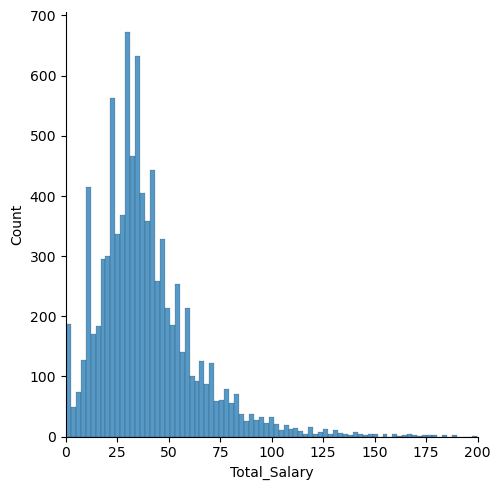

In [7]:
#looked at variable histograms to decide on discretisation bins

import matplotlib.pyplot as plt

sns.displot(x = df["Total_Salary"])
plt.xlim(0,200)
plt.show()

In [8]:
#fit simple logistic regression model

from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(penalty = "none", fit_intercept=False,max_iter=10000)

lrmod = logr.fit(X_train,y_train)

In [9]:
#quick look at confusion matrix

from sklearn.metrics import confusion_matrix

y_pred_lr = logr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred_lr)
cnf_matrix

array([[515, 127],
       [197, 952]])

In [45]:
#print regression coefficients

logr.coef_

array([[-1.58506268e-02, -1.23771176e-04, -1.12526716e-01,
         1.74043135e-02, -1.21775162e-05, -3.66337568e-05,
         5.45413474e-02,  6.86306279e-03,  6.44141581e-01,
         2.93138169e+00]])

In [10]:
#key metrics

import sklearn.metrics as metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

Accuracy: 0.8190954773869347
Precision: 0.8822984244670992
Recall: 0.8285465622280244


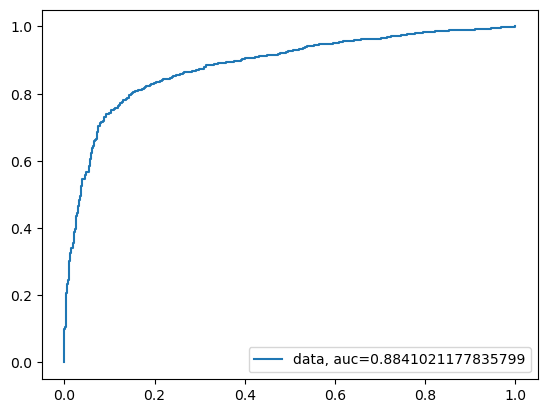

In [12]:
y_pred_proba = logr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### CausalNex

In [13]:
#create structure model instance

from causalnex.structure import StructureModel
sm = StructureModel()

In [14]:
#run notears causal discovery algorithm on the dataset

from causalnex.structure.notears import from_pandas
sm = from_pandas(df,max_iter=400)

/Users/tomgvero/opt/anaconda3/envs/Diss/lib/python3.8/site-packages/causalnex/structure/notears.py:440: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


In [15]:
from IPython.display import Image

In [16]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

/Users/tomgvero/opt/anaconda3/envs/Diss/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Term', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


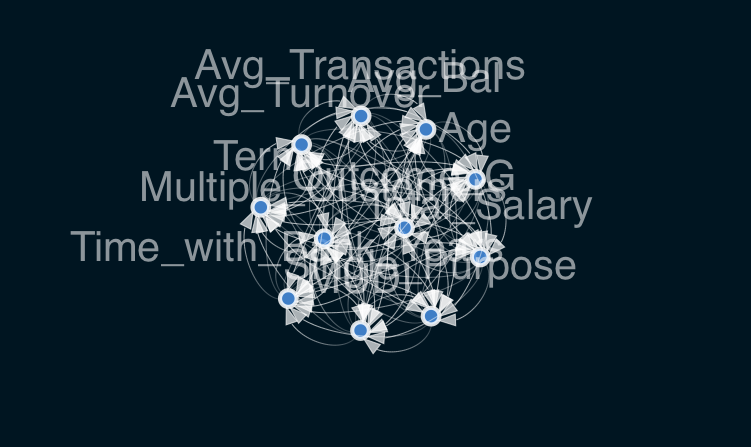

In [17]:
#print initial graph 

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

/Users/tomgvero/opt/anaconda3/envs/Diss/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Term', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


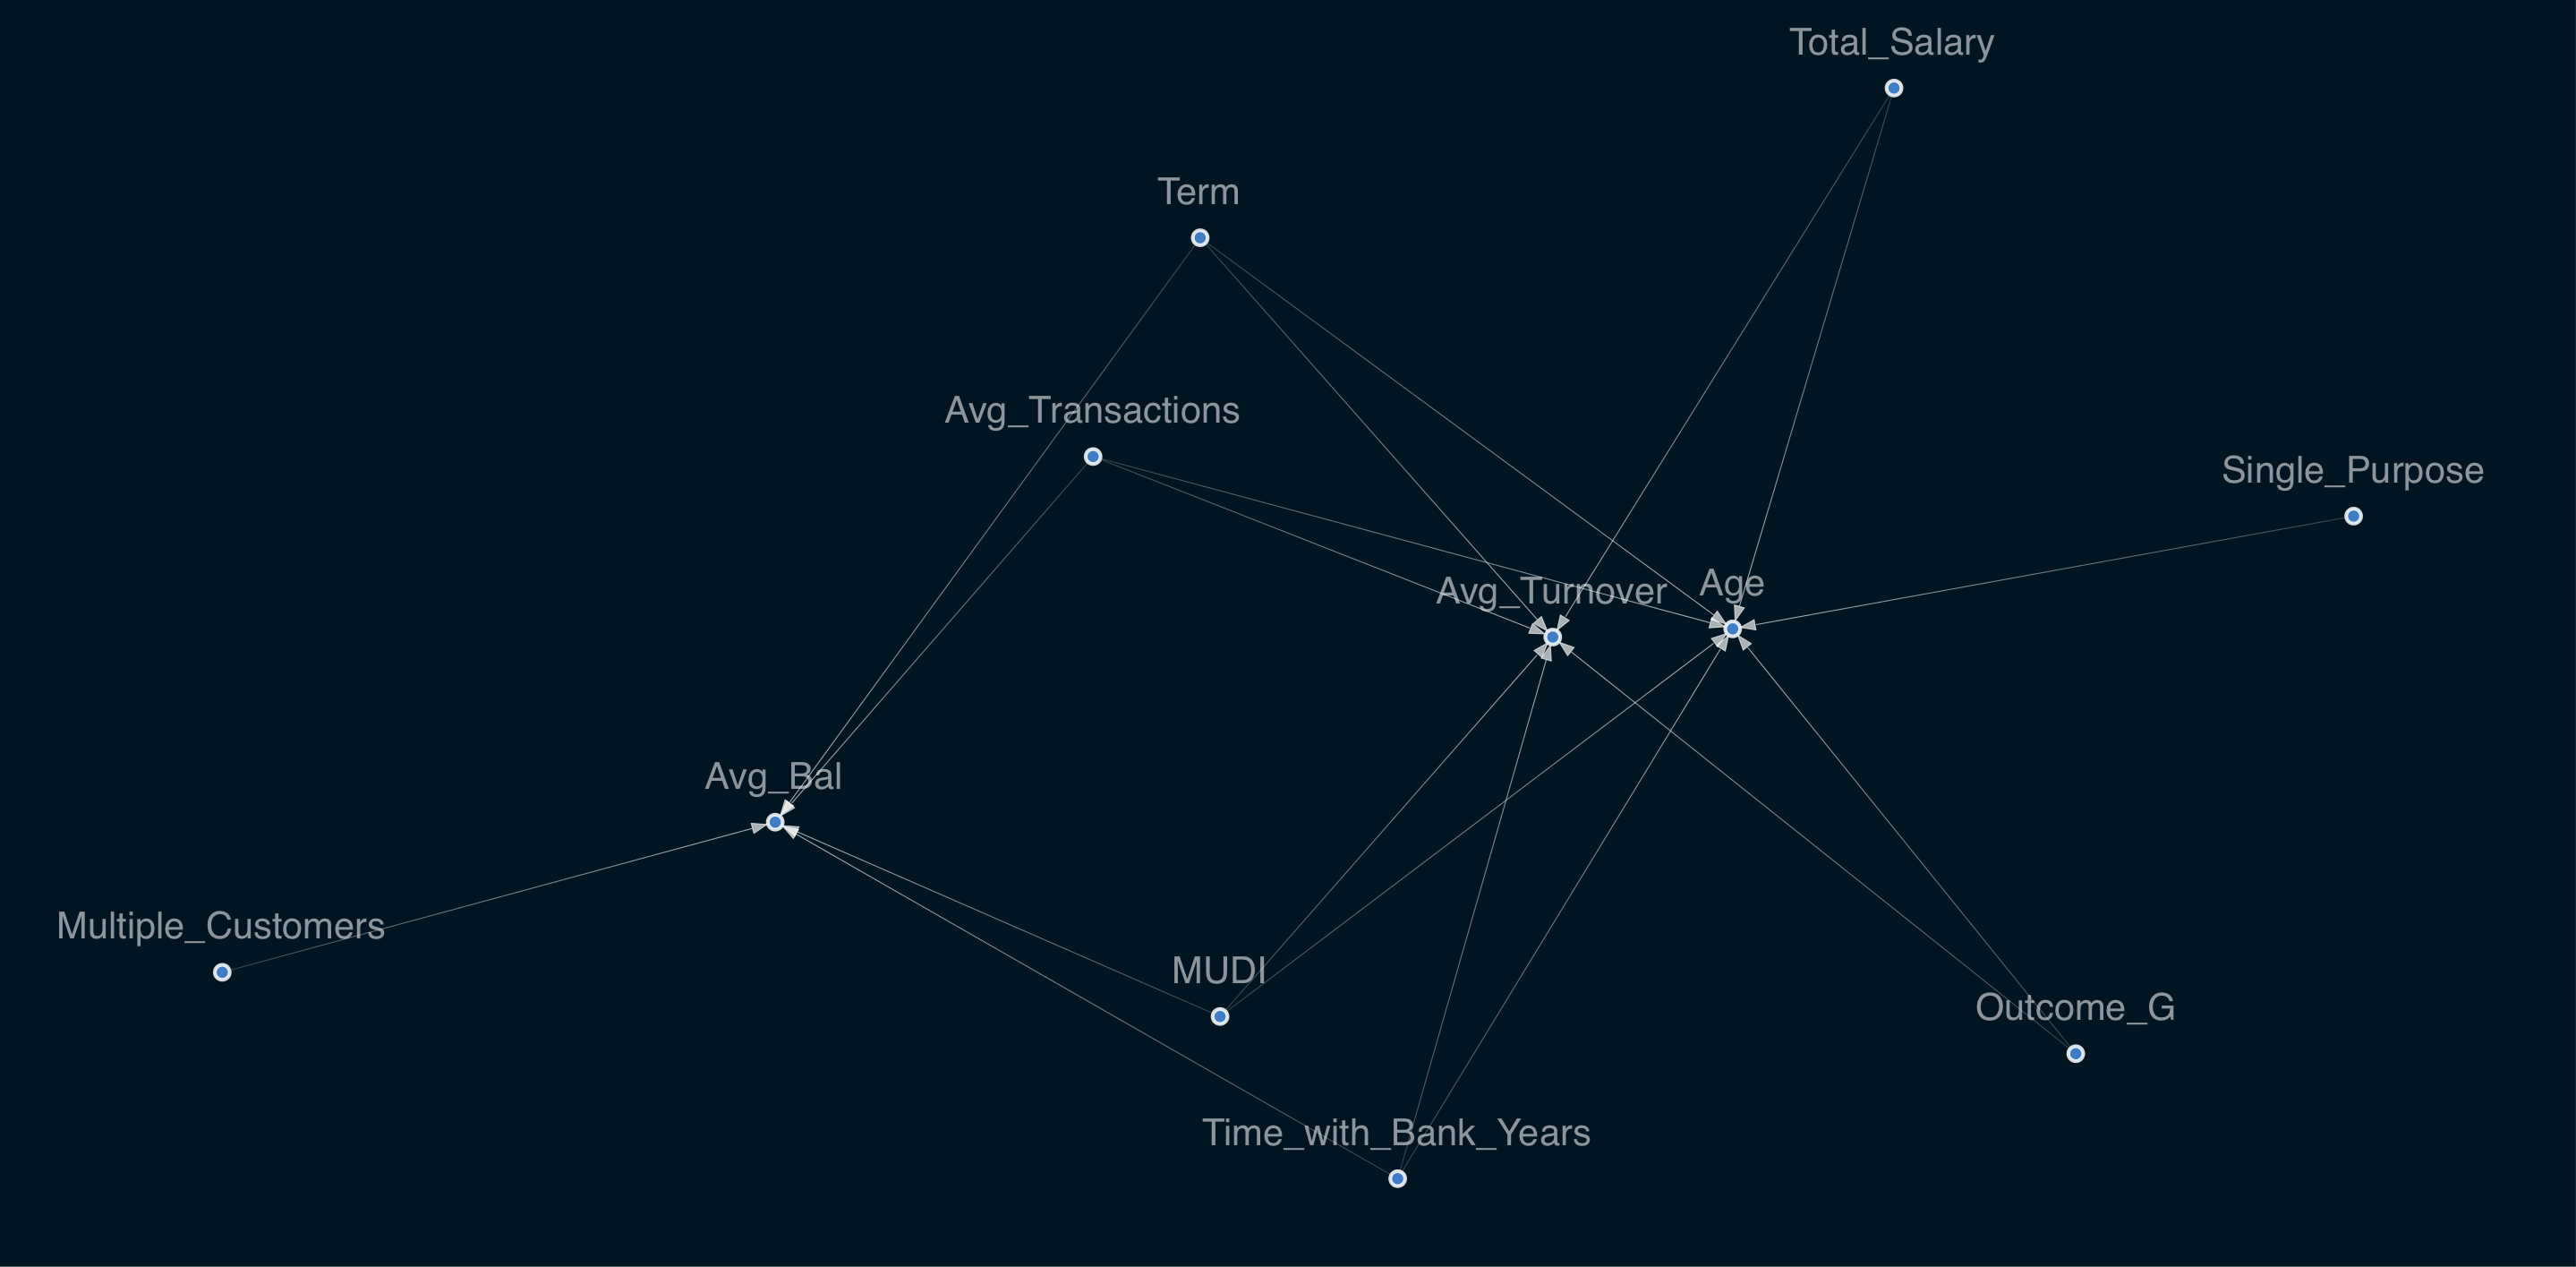

In [18]:
#no edge will have a weight of exactly zero so we have a fully connected graph

#need to remove edges below a certain weight to give us the most important relationships

sm.remove_edges_below_threshold(2)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

#Edges with high variance (i.e. with high absolute value) are favoured as sinks (see literature) so we need to normalise the data

In [19]:
#normalise data for causal discovery 

data_norm =(df-df.mean())/df.std()
data_norm

,Term,Age,MUDI,Avg_Transactions,Avg_Bal,Avg_Turnover,Time_with_Bank_Years,Total_Salary,Multiple_Customers,Single_Purpose,Outcome_G
0,0.709558,1.255017,2.196602,-1.358574,0.486349,-0.653929,0.160590,0.165632,-0.485446,-1.014907,-1.414135
1,-0.373649,-0.434937,0.678577,0.137216,-0.426502,-0.130502,-0.060009,-0.134335,-0.485446,-1.014907,-1.414135
2,0.709558,-0.880035,-0.333440,-1.306995,0.049064,-0.609839,-0.721805,-0.634280,-0.485446,-1.014907,-1.414135
3,-0.373649,-2.023813,-0.333440,0.498268,-0.357030,-0.220189,-1.383600,-1.100896,-0.485446,-1.014907,-1.414135
4,0.709558,-0.702705,-0.839449,-0.636469,-0.376069,-0.128806,0.160590,0.332281,-0.485446,-1.014907,-1.414135
...,...,...,...,...,...,...,...,...,...,...,...
8950,0.709558,-0.786937,-0.333440,0.240373,-0.287559,0.034176,-1.163002,0.065643,-0.485446,0.985202,0.707067
8951,-0.373649,0.630816,-0.839449,0.498268,-0.451212,-0.122400,1.925379,2.298732,2.059733,0.985202,0.707067
8952,-0.373649,-1.145143,-0.839449,0.291952,-0.394906,-0.252032,-1.604199,-0.334313,-0.485446,0.985202,0.707067
8953,0.709558,-1.760478,2.196602,0.343531,-0.174946,-0.116559,0.160590,-0.434302,-0.485446,-1.014907,0.707067


In [20]:
#re-run discovery with normalised data

sm_norm = from_pandas(data_norm,max_iter=400)

/Users/tomgvero/opt/anaconda3/envs/Diss/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Term', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/Users/tomgvero/opt/anaconda3/envs/Diss/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'Term', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


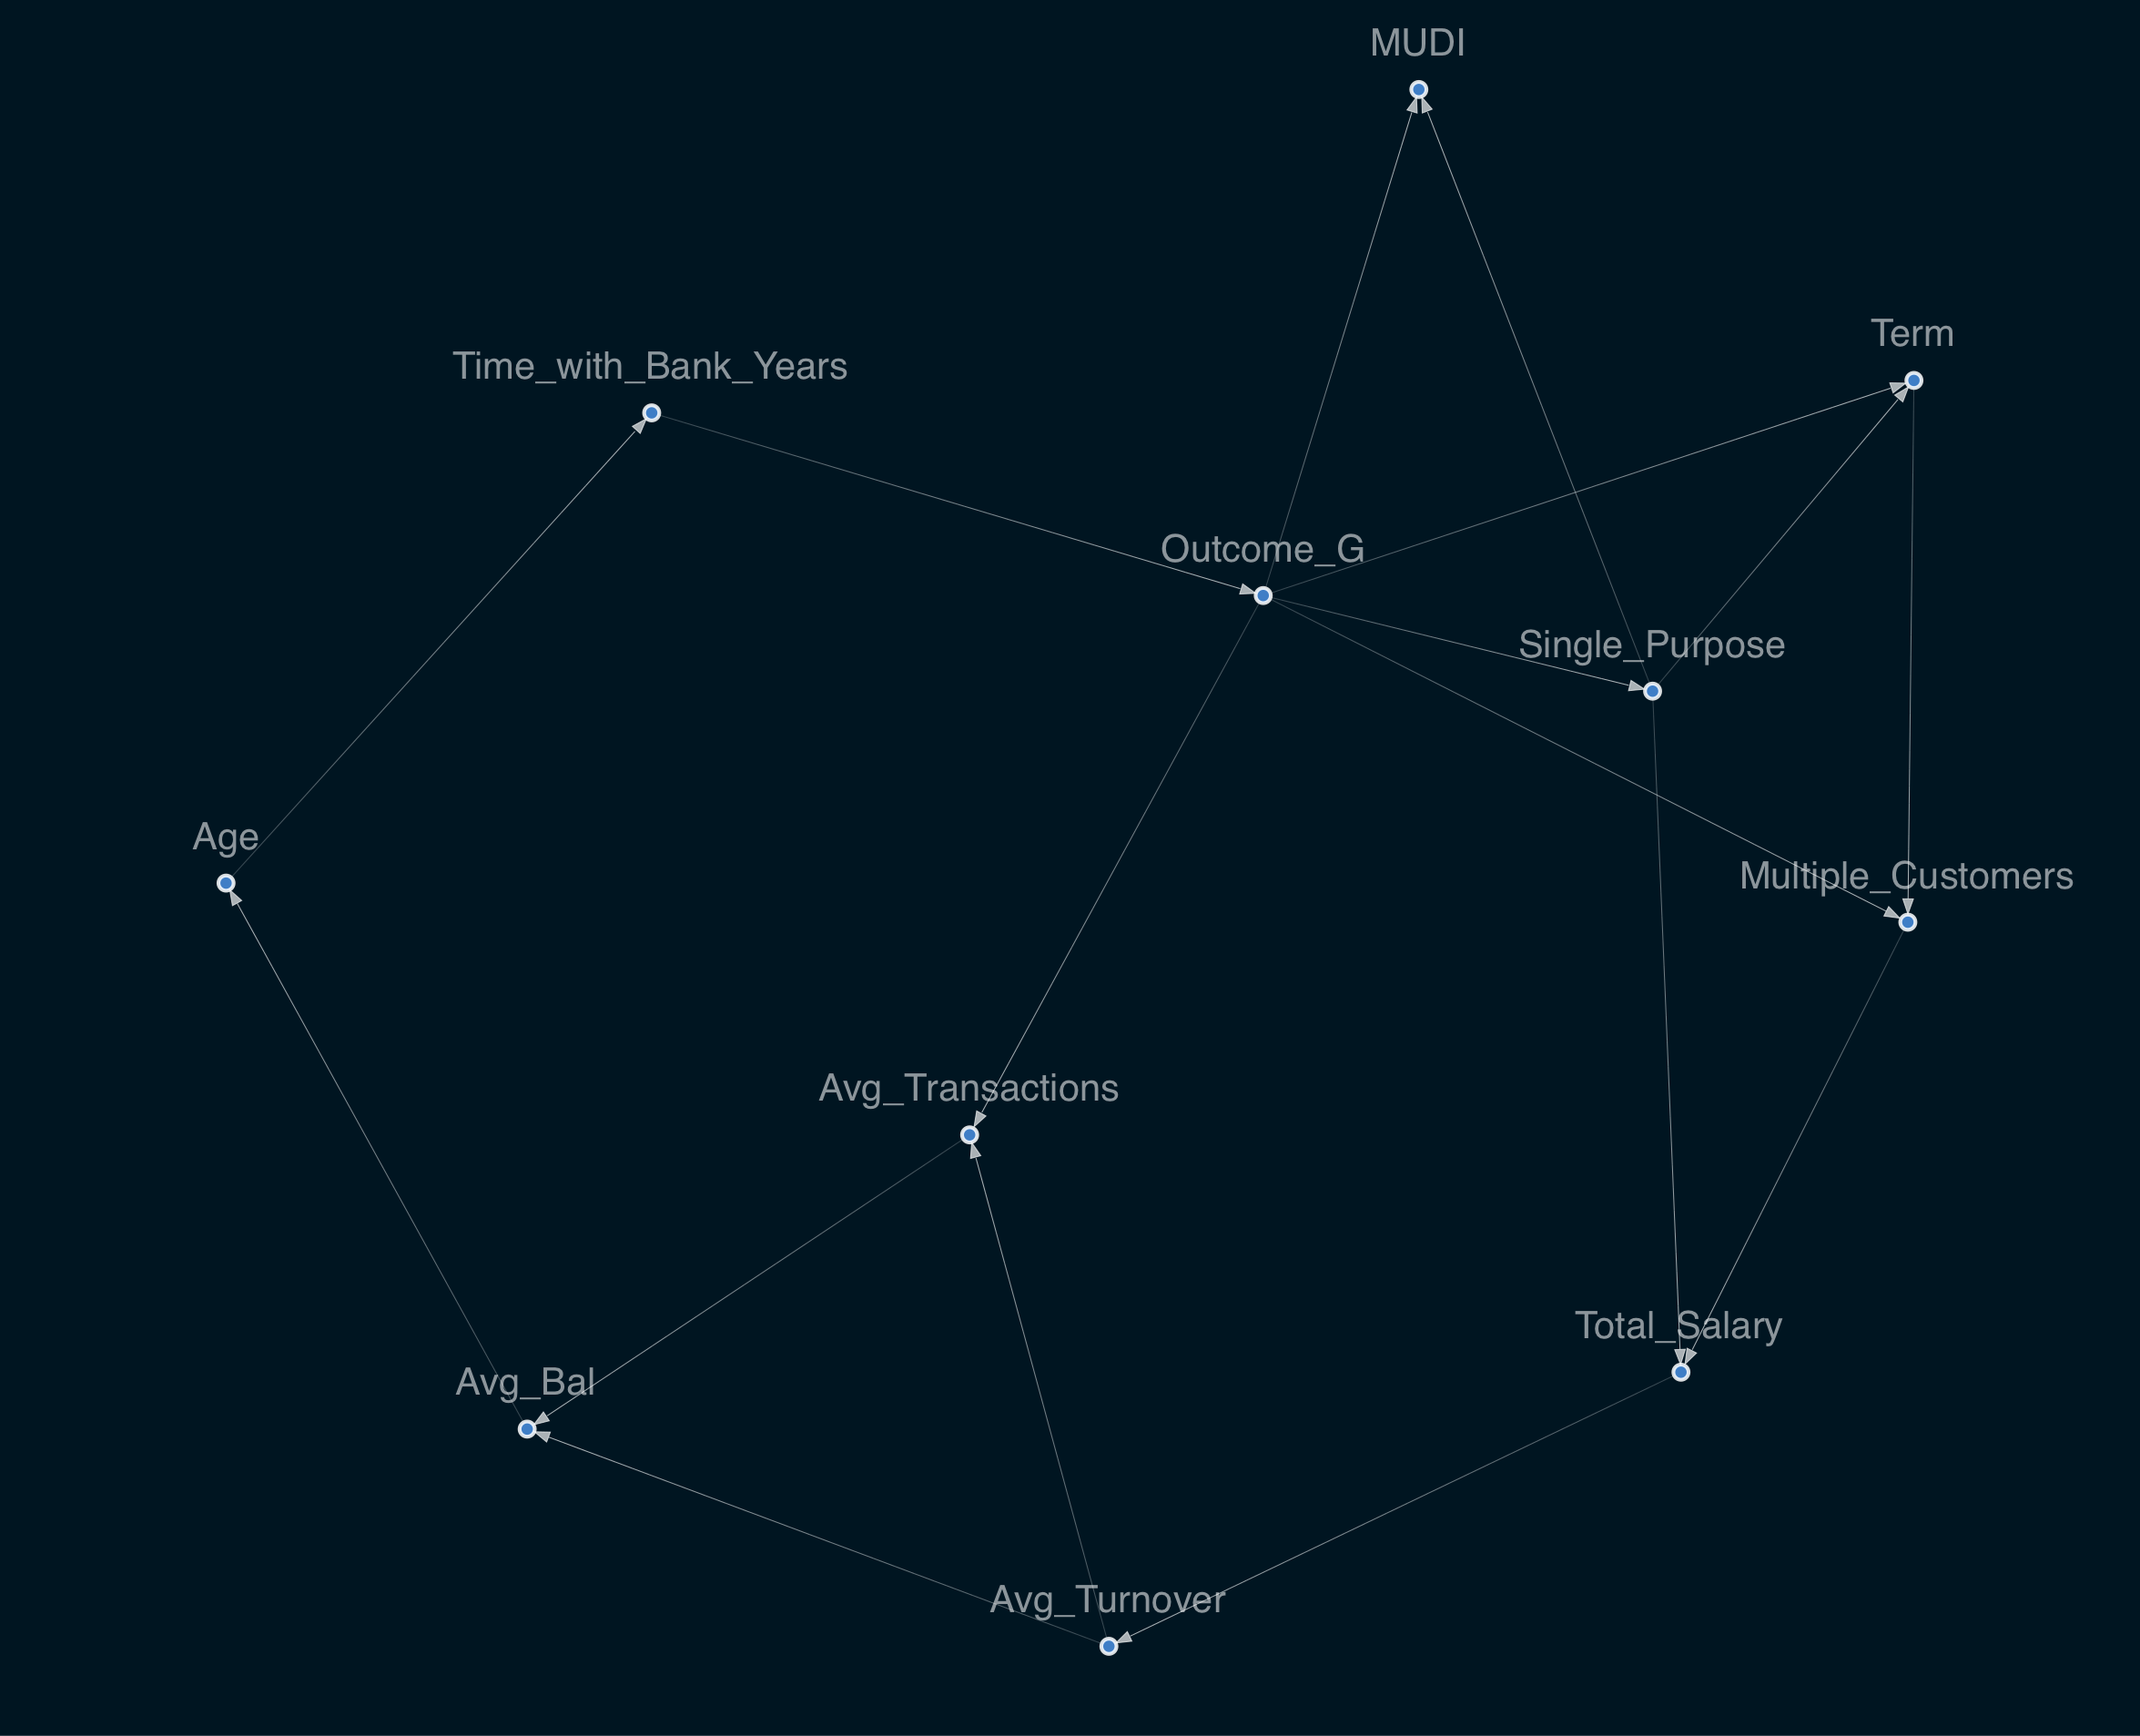

In [21]:
#print new graph 

sm_norm.remove_edges_below_threshold(0.1)
viz = plot_structure(
    sm_norm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [48]:
#implement constraints reflecting logical assumptions about causal patterns in the data

sm_norm_con = from_pandas(data_norm,tabu_parent_nodes = ["Outcome_G"],tabu_child_nodes = ["Age","Multiple_Customers"])

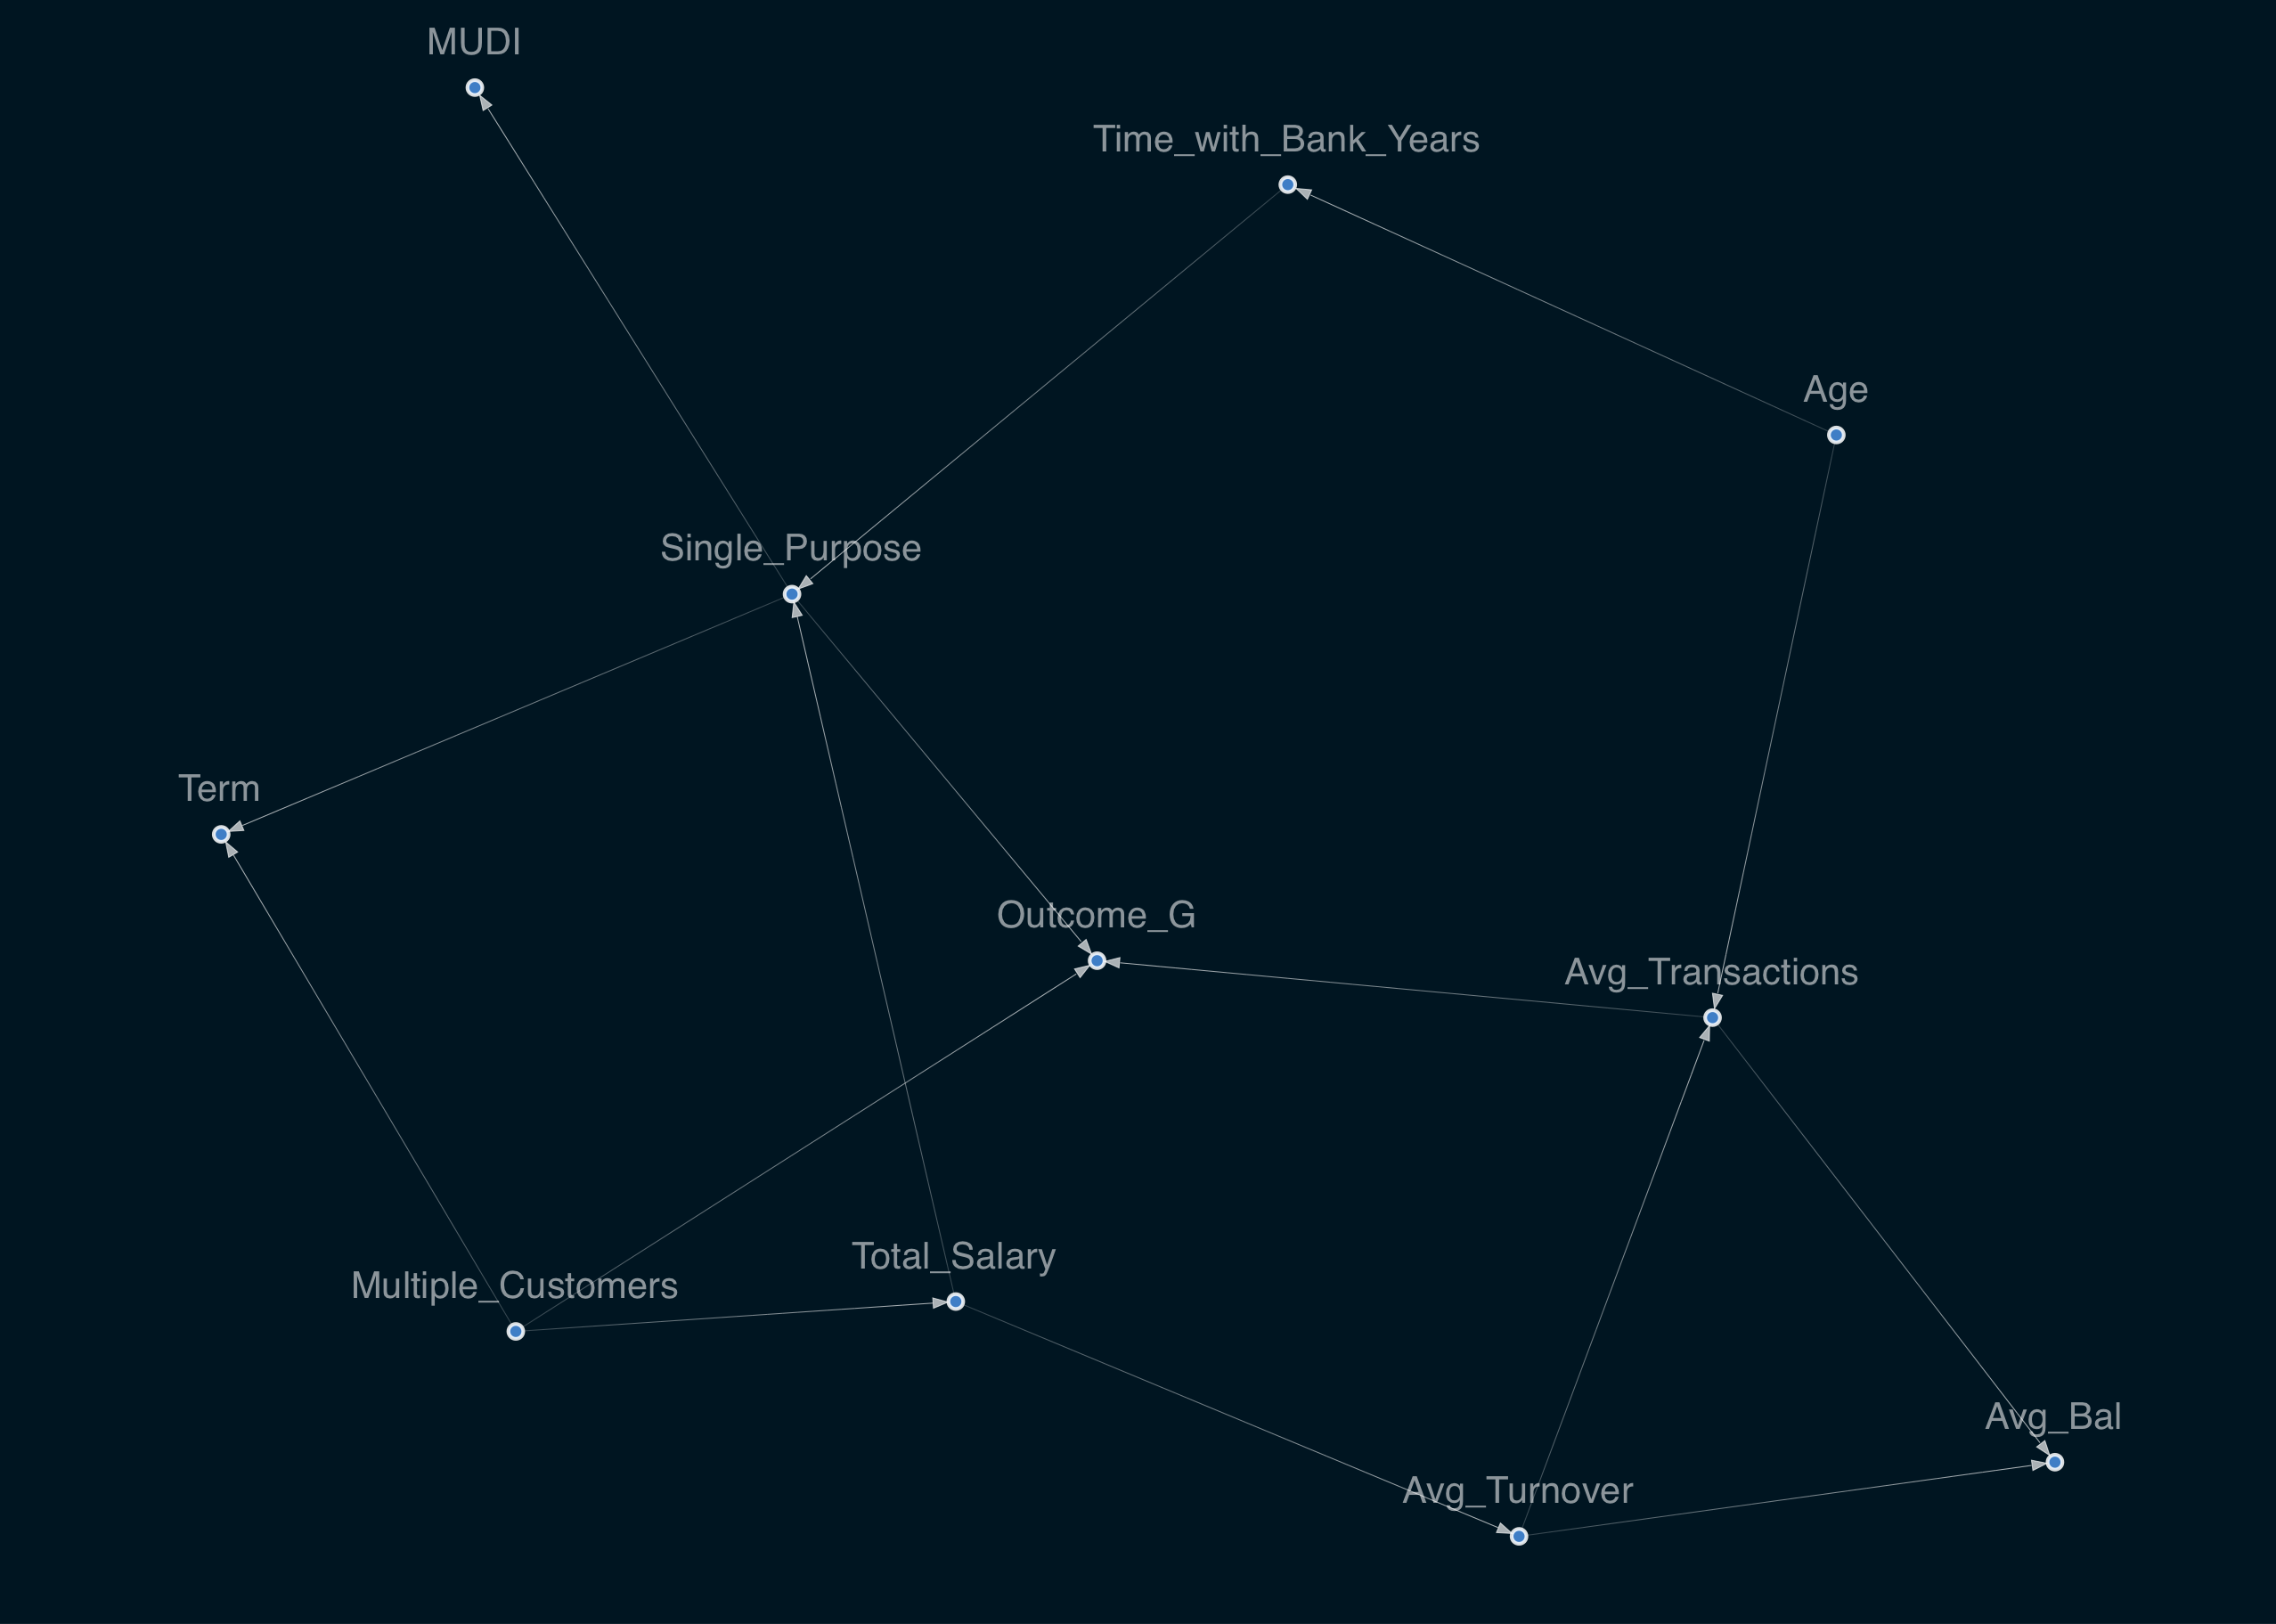

In [49]:
#print final graph 

sm_norm_con.remove_edges_below_threshold(0.1)
viz = plot_structure(
    sm_norm_con,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

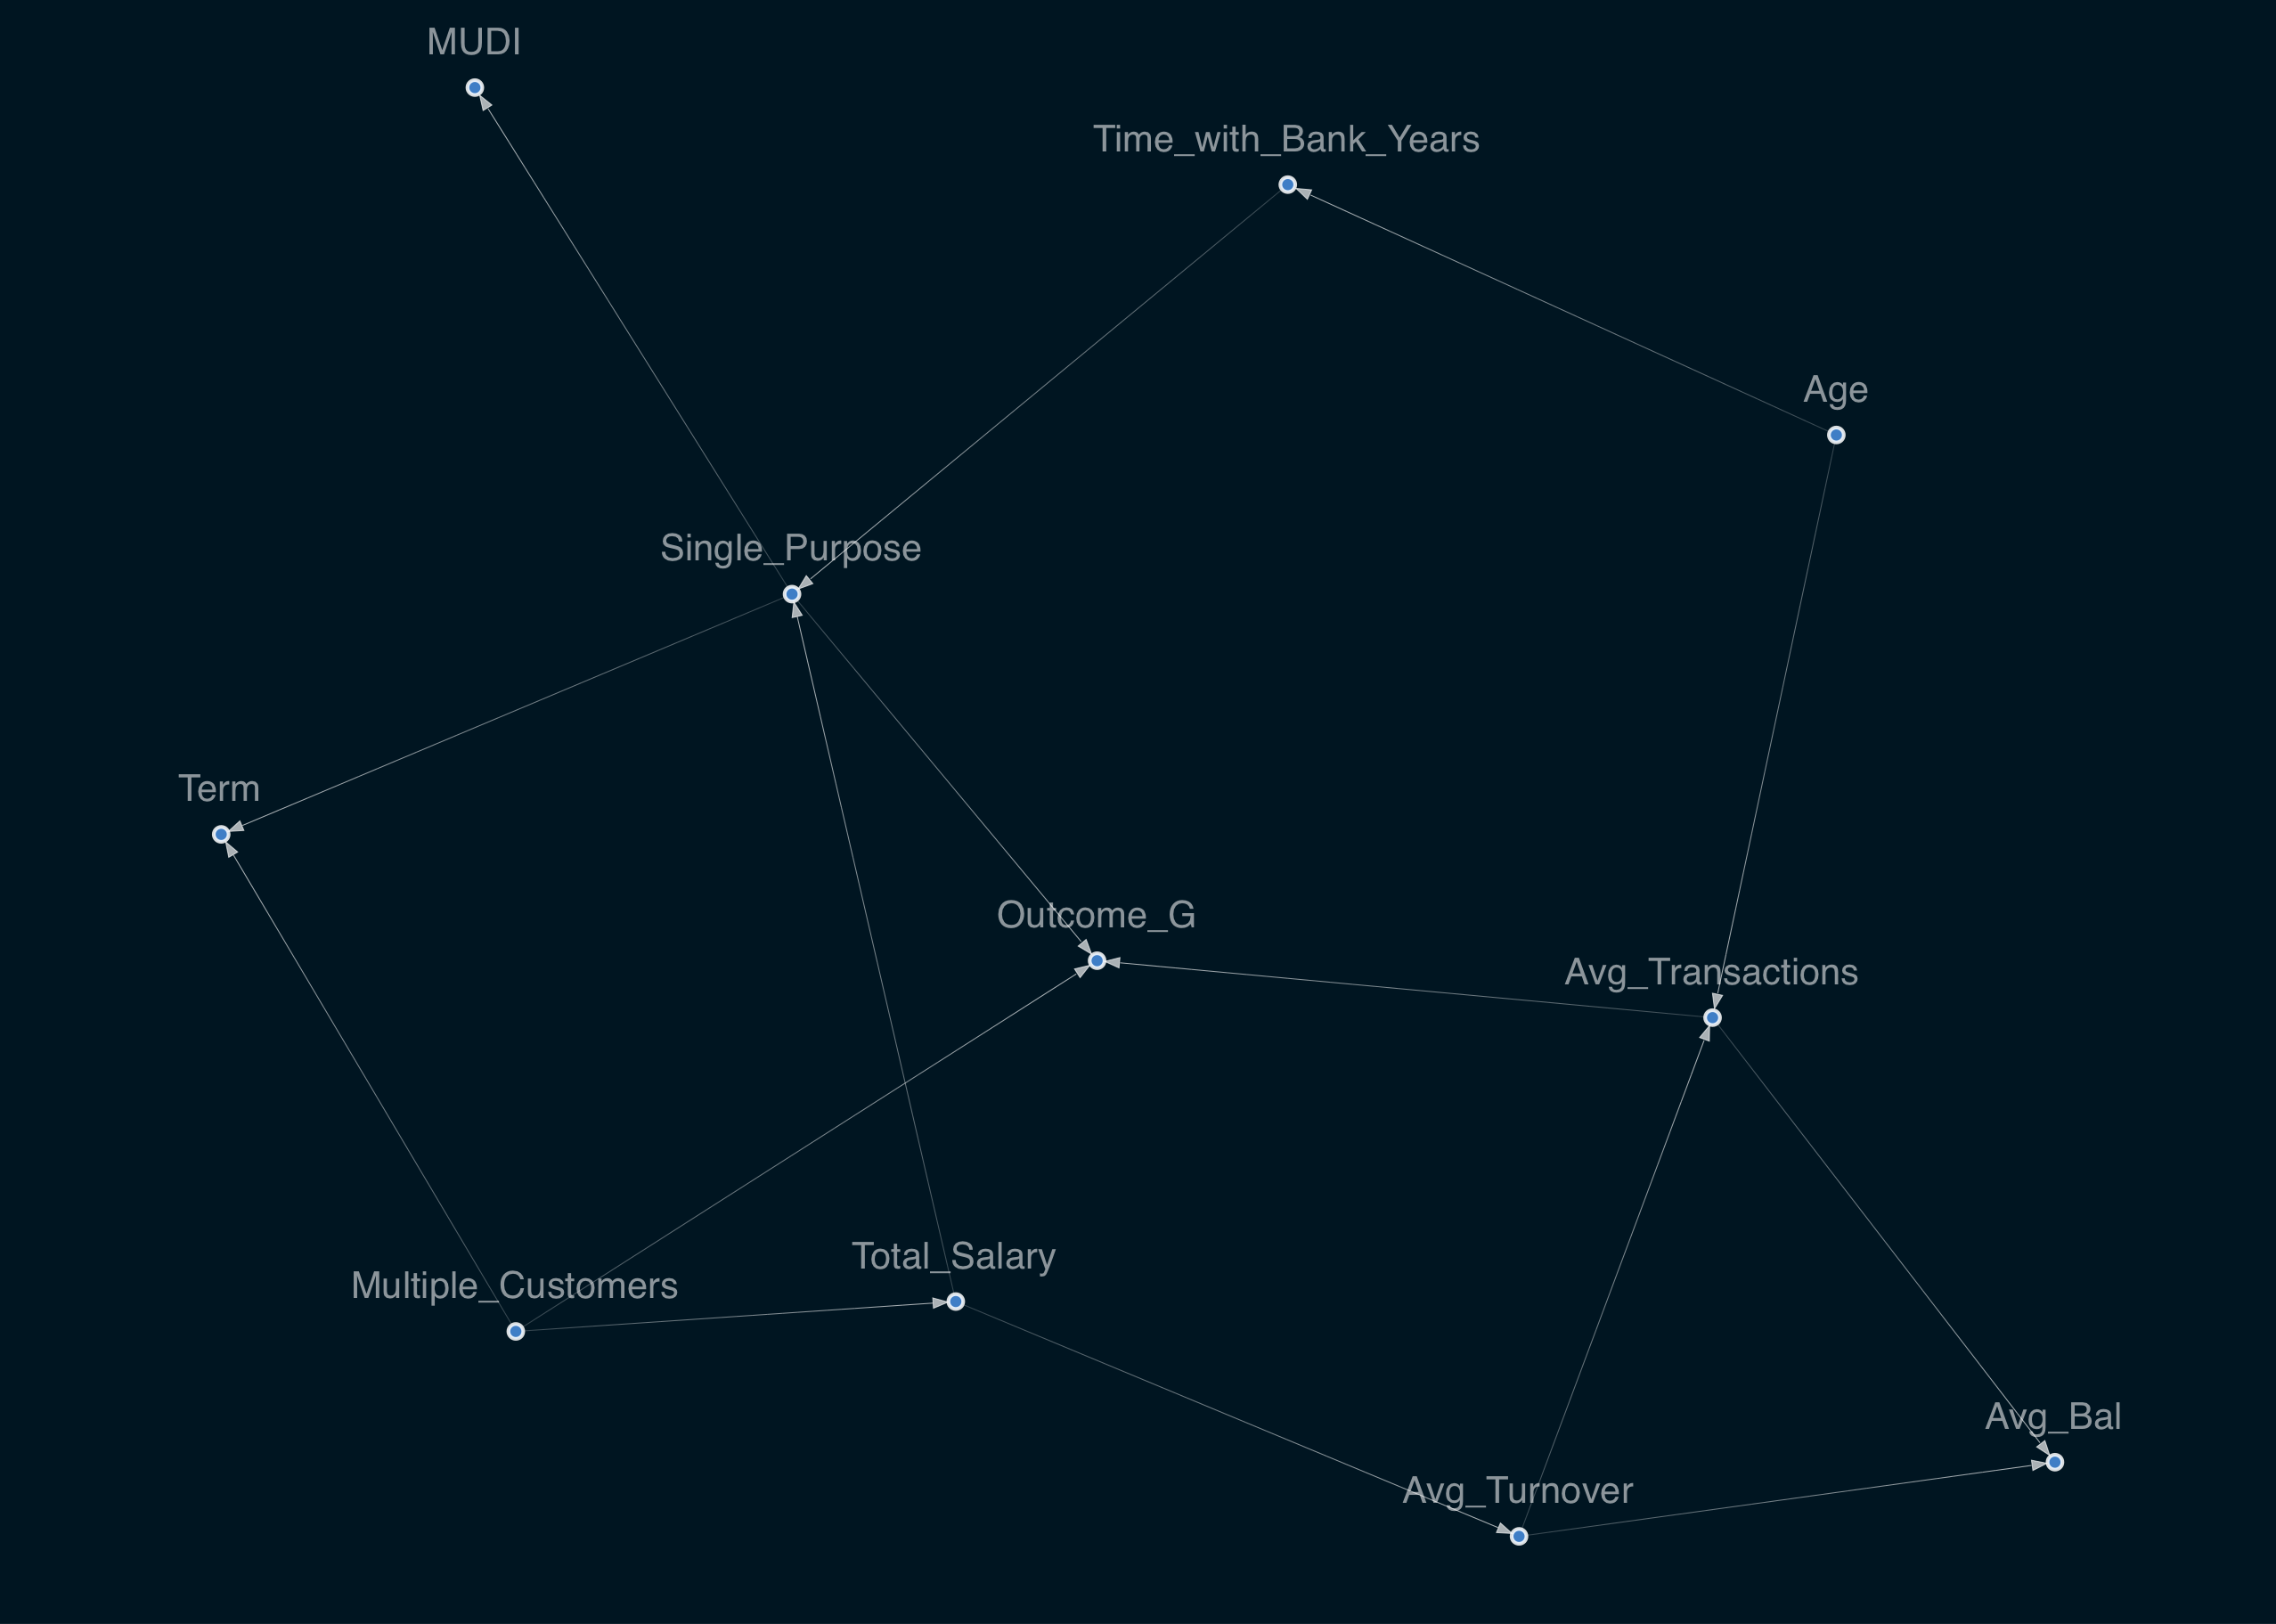

In [50]:
sm_final = sm_norm_con.get_largest_subgraph()

viz = plot_structure(
    sm_final,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [51]:
#instantiate bayesian network on our final structure

from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm_final)

In [52]:
discretised_data = df.copy()

discretised_data

,Term,Age,MUDI,Avg_Transactions,Avg_Bal,Avg_Turnover,Time_with_Bank_Years,Total_Salary,Multiple_Customers,Single_Purpose,Outcome_G
0,60,5608,6,1,4642,100,10,45,0,0,0
1,36,3702,3,30,135,2878,9,36,0,0,0
2,60,3200,1,2,2483,334,6,21,0,0,0
3,36,1910,1,37,478,2402,3,7,0,0,0
4,60,3400,0,15,384,2887,10,50,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8950,60,3305,1,32,821,3752,4,42,0,1,1
8951,36,4904,0,37,13,2921,18,109,1,1,1
8952,36,2901,0,33,291,2233,2,30,0,1,1
8953,60,2207,6,34,1377,2952,10,27,0,0,1


In [53]:
from causalnex.discretiser import Discretiser

#discretise each numerical variable into bins based on looking at histograms

discretised_data["Age"] = Discretiser(method="fixed",
                          numeric_split_points=[3000, 6000]).transform(discretised_data["Age"].values)

discretised_data["Avg_Transactions"] = Discretiser(method="fixed",
                          numeric_split_points=[25, 50]).transform(discretised_data["Avg_Transactions"].values)

discretised_data["Avg_Bal"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 1000, 2500]).transform(discretised_data["Avg_Bal"].values)

discretised_data["Avg_Turnover"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 2500, 5000]).transform(discretised_data["Avg_Turnover"].values)

discretised_data["Time_with_Bank_Years"] = Discretiser(method="fixed",
                          numeric_split_points=[10, 20]).transform(discretised_data["Time_with_Bank_Years"].values)

discretised_data["Total_Salary"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 30, 60]).transform(discretised_data["Total_Salary"].values)

In [54]:
Age_map = {0: "Under 30", 1: "30-59", 2: "60+"}
ATr_map = {0: "<25", 1:"25-49", 2: ">=50"}
ABal_map = {0: "0", 1: "1-999", 2: "1000-2499", 3: ">=2500"}
ATu_map = {0: "0", 1: "1-2499", 2: "2500-4999", 3: ">=5000"}
TwB_map = {0: "<10", 1:"10-19", 2: ">=20"}
Sal_map = {0: "0", 1: "1-29", 2: "30-59", 3: ">=60"}

discretised_data["Age"] = discretised_data["Age"].map(Age_map)
discretised_data["Avg_Transactions"] = discretised_data["Avg_Transactions"].map(ATr_map)
discretised_data["Avg_Bal"] = discretised_data["Avg_Bal"].map(ABal_map)
discretised_data["Avg_Turnover"] = discretised_data["Avg_Turnover"].map(ATu_map)
discretised_data["Time_with_Bank_Years"] = discretised_data["Time_with_Bank_Years"].map(TwB_map)
discretised_data["Total_Salary"] = discretised_data["Total_Salary"].map(Sal_map)

In [55]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=100)

In [75]:
bn = bn.fit_node_states(discretised_data)

In [76]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [77]:
bn.cpds["Outcome_G"]

Avg_Transactions   25-49                                     <25            \
Multiple_Customers     0                   1                   0             
Single_Purpose         0         1         0         1         0         1   
Outcome_G                                                                    
0                   0.55  0.064944  0.466418  0.027607  0.734852  0.066574   
1                   0.45  0.935056  0.533582  0.972393  0.265148  0.933426   

Avg_Transactions                            >=50                                
Multiple_Customers         1                   0                   1            
Single_Purpose             0         1         0         1         0         1  
Outcome_G                                                                       
0                   0.420139  0.025424  0.545455  0.067568  0.288889  0.010753  
1                   0.579861  0.974576  0.454545  0.932432  0.711111  0.989247

In [59]:
discretised_data.loc[18, discretised_data.columns != 'Outcome_G']

Term                        60
Age                      30-59
MUDI                         6
Avg_Transactions           <25
Avg_Bal                  1-999
Avg_Turnover            1-2499
Time_with_Bank_Years     10-19
Total_Salary                 0
Multiple_Customers           0
Single_Purpose               0
Name: 18, dtype: object

In [60]:
predictions = bn.predict(discretised_data, "Outcome_G")

In [61]:
print('The prediction is \'{prediction}\''.format(prediction=predictions.loc[18, 'Outcome_G_prediction']))

The prediction is '0'


In [62]:
print('The ground truth is \'{truth}\''.format(truth=discretised_data.loc[18, 'Outcome_G']))

The ground truth is '0'


In [37]:
from causalnex.evaluation import classification_report
classification_report(bn, test, "Outcome_G")

{'Outcome_G_0': {'precision': 0.6770833333333334,
  'recall': 0.8201892744479495,
  'f1-score': 0.7417974322396577,
  'support': 317},
 'Outcome_G_1': {'precision': 0.888671875,
  'recall': 0.7858376511226253,
  'f1-score': 0.8340971585701191,
  'support': 579},
 'accuracy': 0.7979910714285714,
 'macro avg': {'precision': 0.7828776041666667,
  'recall': 0.8030134627852874,
  'f1-score': 0.7879472954048884,
  'support': 896},
 'weighted avg': {'precision': 0.8138129824683781,
  'recall': 0.7979910714285714,
  'f1-score': 0.8014420098572215,
  'support': 896}}

In [38]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "Outcome_G")
print(auc)
print(roc)

0.8775809151785715
[(0.0, 0.0), (0.0011160714285714285, 0.020089285714285716), (0.0011160714285714285, 0.06473214285714286), (0.002232142857142857, 0.10602678571428571), (0.021205357142857144, 0.29575892857142855), (0.03236607142857143, 0.4296875), (0.033482142857142856, 0.4642857142857143), (0.09486607142857142, 0.6584821428571429), (0.09821428571428571, 0.6618303571428571), (0.11607142857142858, 0.6785714285714286), (0.17745535714285715, 0.7633928571428571), (0.19308035714285715, 0.7745535714285714), (0.20200892857142858, 0.7979910714285714), (0.22544642857142858, 0.8069196428571429), (0.23660714285714285, 0.8225446428571429), (0.32142857142857145, 0.8839285714285714), (0.33816964285714285, 0.9017857142857143), (0.34151785714285715, 0.9051339285714286), (0.5357142857142857, 0.9665178571428571), (0.5703125, 0.9676339285714286), (0.7042410714285714, 0.9787946428571429), (0.8939732142857143, 0.9977678571428571), (0.9352678571428571, 0.9988839285714286), (0.9799107142857143, 0.9988839285

Shows performance is pretty good when compared with logistic regression. We can now show the addded functionality that we can benefit from using causalnex with respect to interpretability. 

In [160]:
#update model to use complete dataset rather than just training

bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

#can ignore warnings

In [161]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["Outcome_G"]

{0: 0.3312628350006345, 1: 0.6687371649993655}

In [162]:
#sanity check - confirms these marginals agree with the real proportion in the data

import numpy as np
labels, counts = np.unique(discretised_data["Outcome_G"], return_counts=True)
list(zip(labels, counts))

[(0, 2985), (1, 5970)]

In [165]:
marginals_single = ie.query({"Multiple_Customers": 0})
marginals_partner = ie.query({"Multiple_Customers": 1})

print("Marginal Good | Single", marginals_single["Outcome_G"])
print("Marginal Good | Not Single", marginals_partner["Outcome_G"])

#see here that according to model you are a lot more likely to be accepted if you have a partner, everything else equal 

Marginal Good | Single {0: 0.3634095720880883, 1: 0.6365904279119118}
Marginal Good | Not Single {0: 0.19510930262739604, 1: 0.8048906973726039}


In [ ]:
#do calculus 

